In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

### Creating model

In [2]:
#intialising hyperparameters
in_channels = 3
num_classes = 2

batch_size = 64
learning_rate = 0.01

linear_first_dimension = 2048
num_epochs = 3

In [3]:
class CNN(nn.Module):
    def __init__(self, in_channels=in_channels, num_classes=num_classes):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels, 8, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.cnn2 = nn.Conv2d(8, 16, kernel_size=(3,3), padding=(1,1), stride=(1,1))
#         self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.cnn3 = nn.Conv2d(16,32, kernel_size=(3,3), padding=(1,1),stride=(1,1))
        self.fc1 = nn.Linear(linear_first_dimension,num_classes)
    
    def forward(self, x):
        out = self.pool(self.cnn1(x))
        out = self.pool(self.cnn2(out))
        out = self.pool(self.cnn3(out))
        out = out.reshape(out.size(0), -1)
#         print(out.shape)
        out = self.fc1(out)
        return out

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
model = CNN().to(device=device)

#testing
x = torch.randn(64,3,64,64).to(device=device)
y = model(x)
y.shape

torch.Size([64, 2])

### Working with Dataset

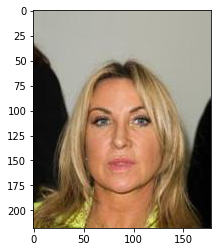

In [6]:
import matplotlib.pyplot as plt
img = Image.open('../input/celeba-dataset/img_align_celeba/img_align_celeba/000022.jpg')
plt.imshow(img)

In [7]:
img._size

(178, 218)

In [8]:
import pandas as pd
df = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [9]:
a = df[['Attractive','image_id']]
a.head()

,Attractive,image_id
0,1,000001.jpg
1,-1,000002.jpg
2,-1,000003.jpg
3,1,000004.jpg
4,1,000005.jpg


In [10]:
a.iloc[:,0]

0         1
1        -1
2        -1
3         1
4         1
         ..
202594    1
202595   -1
202596   -1
202597    1
202598    1
Name: Attractive, Length: 202599, dtype: int64

In [11]:
a['target'] = [0 if x==-1 else 1 for x in a.iloc[:,0]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
a.head()

,Attractive,image_id,target
0,1,000001.jpg,1
1,-1,000002.jpg,0
2,-1,000003.jpg,0
3,1,000004.jpg,1
4,1,000005.jpg,1


In [13]:
imagepath = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
csvpath = "../input/celeba-dataset/list_attr_celeba.csv"

In [14]:
import os

In [15]:
os.path.join(imagepath,a['image_id'][0])

'../input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg'

In [16]:
my_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.Resize((64,64)),
])

In [17]:
img = my_transforms(img)
img.size

(64, 64)

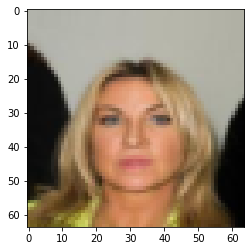

In [18]:
plt.imshow(img)

### Creating pytorch Dataset class

In [19]:
class CelebAttractivenessDataset(Dataset):
    def __init__(self, imagepath=imagepath, csvpath=csvpath, transform=None):
        df = pd.read_csv(csvpath)
        a = df[['Attractive','image_id']]
        a['target'] = [0 if x==-1 else 1 for x in a.iloc[:,0]]
        self.y = a['target']
        self.x = a['image_id']
        self.n_samples = len(a)
        self.transform = transform
        
    def __getitem__(self,index):
        img = Image.open(os.path.join(imagepath, self.x[index])).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
#         img_tensor = np.array(img)
        return transforms.functional.to_tensor(img), self.y[index]
    
    def __len__(self):
        return self.n_samples

1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


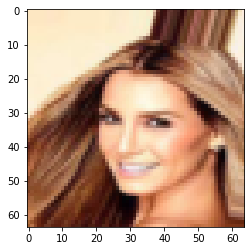

In [20]:
train_dataset = CelebAttractivenessDataset(transform=my_transforms)
img, y = train_dataset[0]

plt.imshow(img.permute(1,2,0))
print(y)

In [21]:
img.shape

torch.Size([3, 64, 64])

### Creating a DataLoader

In [22]:
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [23]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [24]:
# training
for epoch in range(num_epochs):
    for data, target in train_dataloader:
        data = data.to(device=device)
#         data = data.permute(0,3,1,2)
        target = target.to(device=device)
        
        score = model(data)
        loss = loss_criterion(score, target)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    print(f"For epoch : {epoch} loss: {loss}")

For epoch : 0 loss: 0.5663887858390808
For epoch : 1 loss: 0.47619423270225525
For epoch : 2 loss: 0.3340552747249603


In [25]:
#checking accuracy helper function
def check_accuracy(model, loader):
    total_correct = 0
    total_predictions = 0
    
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x= x.to(device=device)
            y= y.to(device=device)
            y_pred = model(x)
            _, prediction = y_pred.max(1)
        
            total_correct +=  (y==prediction).sum()
            total_predictions += prediction.shape[0]
    
    print(f" the accuracy: {(total_correct/total_predictions)*100}")
    model.train()
        

In [26]:
check_accuracy(model, train_dataloader)
check_accuracy(model, test_dataloader)

 the accuracy: 79.0073013305664


NameError: name 'test_dataloader' is not defined